# BayesFrag - Tutorial 2: Application to a realistic damage data set

<a target="_blank" href="https://colab.research.google.com/github/bodlukas/BayesFrag/blob/main/Tutorial2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

BayesFrag is a tool to perform Bayesian parameter estimation for empirical seismic fragility models. The tool accounts for uncertainty in the ground motion intensity measures (IMs) which caused the observed damage. The methodology is presented in

>Bodenmann, L., Baker, J., and Stojadinović, B. (2023): Accounting for ground motion uncertainty in empirical seismic fragility modeling, LINK [preprint], doi: LINK.

The employed data set consists of a subset of the L'Aquila data set used in the manuscript but with simulated damage and modified building classes. 

The provided notebook can easily be modified and extended such that analysts can apply BayesFrag to their data sets of interest.

This notebook and further supporting codes are published on [GitHub](https://github.com/bodlukas/BayesFrag) and Zenodo (doi: LINK).

## Import packages

If the notebook runs on google colab, we install [NumPyro](https://github.com/pyro-ppl/numpyro) and clone the [BayesFrag repository](https://github.com/bodlukas/BayesFrag) with the BayesFrag codebase and the tutorial data. 

In [1]:
%%capture
import os
if os.getenv("COLAB_RELEASE_TAG"):
  !pip install numpyro
  !git clone https://github.com/bodlukas/BayesFrag.git
  %cd BayesFrag

In [2]:
import os
import numpyro
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy import stats

numpyro.enable_x64()

# Modify this if you perform inference on GPU
# See Numpyro documentation.
numpyro.set_platform('cpu')

## Specify settings for inference

- IM: Ground motion intensity measure used to estimate fragility functions. For PGA use 'PGA', for SA(T=0.3s) use 'SAT0_300'.
- GMM: Ground motion model that was used to obtain mean, between-event and within-event residuals of logIM at the sites. See the third tutorial for an explanation how to compute these estimates.
- SCM: Spatial correlation model that will be used to condition the IM distribution on station data. For now `modules.spatialcorrelation` contains implementations of `EspositoIervolino2012` [(link to paper)](https://doi.org/10.1785/0120110117) and `BodenmannEtAl2023` [(link to paper)](https://doi.org/10.5194/nhess-23-2387-2023), but users can easily add additional models by following the documentation.
- list_ds: $\mathcal{DS}$, ordered list with possible damage states (including damage state 0!), $ds\in\mathcal{DS}$. Here four damage states $\mathcal{DS}=\{0,1,2,3\}$.
- list_bc: $\mathcal{BC}$, list with considered building classes for which to estimate fragility functions, $bc\in\mathcal{BC}$. Here three classes $\mathcal{BC}=\{\text{A, B, C}\}$.

The MCMC-specific settings are directly explained below.

In [3]:
path_data = os.path.join('data', 'tutorial2', '')

args = {
    'IM': 'SAT0_300',
    'IM_unit': 'g [m/s2]',
    'GMM': 'BindiEtAl2011',
    'SCM': 'EspositoIervolino2012', 
    'list_ds': [0, 1, 2, 3], 
    'list_bc': ['A', 'B', 'C'], 
    'mcmc_seed': 0, # Seed for MCMC
    'mcmc': { # Check numpyro.infer.MCMC for valid settings!
        'num_samples': 750, # Number of samples per Markov chain
        'num_warmup': 1000, # Number of warmup steps per Markov chain
        'num_chains': 4, # Number of Markov chains    
        'chain_method': 'sequential' # Change if parallel chains on multiple cores
            }
        }

### Import damage survey data

This fictitious damage survey data contains information from 4200 buildings. For each building the data set provides:
- coordinates in Longitude and Latitude (decimal degrees)
- building class 
- damage state
- vs30: time-averaged shear wave velocity in the upper-most 30 meters of soil in m/s

Following additional variables were pre-computed from the rupture information and using a GMM (see Tutorial 3)
- mu_logIM: Mean of logIM as obtained from a GMM
- tau_logIM: Standard deviation of logIM between-event residual as obtained from a GMM
- phi_logIM: Standard deviation of logIM within-event residual as obtained from a GMM

In [4]:
df = pd.read_csv(path_data + 'survey.csv', index_col = 'id')
res_gmm = np.load(path_data + 'survey_im_' + args['IM'] + 
                '_gmm_' + args['GMM'] + '.npz')
for key, value in res_gmm.items():
    df[key] = value
print(df.columns.values)

['Longitude' 'Latitude' 'vs30' 'BuildingClass' 'DamageState' 'mu_logIM'
 'tau_logIM' 'phi_logIM']


We initialize a Sites object that collects the required attributes for the subsequent computations. 

Here, we initialize it using a `column_site_mapping` that maps the dataframe columns (right) to site attributes (left). Modify the right entries of this mapping, if your data set uses different column names. 

> **_NOTE:_**  To use the spatial correlation model BodenmannEtAl2023, specify also the columns that contain 'vs30' and 'epiazimuth'. The latter is the epicentral azimuth and is assumed to be pre-computed with a GMM library (see Tutorial 3).

In [5]:
from bayesfrag.sites import Sites
# Mapping from dataframe columns (right) to site attributes (left)
column_site_mapping = {
    'coordinates': ['Longitude', 'Latitude'],
    'mu_logIM': 'mu_logIM',
    'tau_logIM': 'tau_logIM',
    'phi_logIM': 'phi_logIM'
}
# Initialize Sites
survey_sites = Sites.from_df(df, column_site_mapping)

Extract the observed building classes and damage states. These should be encoded as integers. Below, we use `pd.Categorical` to transform building classes and damage states to integers.

In [6]:
obs_BC = pd.Categorical(df.BuildingClass.values, categories = args['list_bc'], 
                        ordered=True).codes
obs_DS = pd.Categorical(df.DamageState.values, categories = args['list_ds'], 
                        ordered = True).codes

### Import station data

This fictitious station data set contains information from 64 stations. For each station the data set provides the same attributes as for the surveyed buildings with the exception of BuildingClass and DamageState. Additionally it provides the observed logIM value as obtained from the ground motion recordings (see Tutorial 3). 

In [7]:
df = pd.read_csv(path_data + 'stations.csv', index_col = 'id', 
                    usecols = ['id', 'Longitude', 'Latitude', 'vs30'])
res_gmm = np.load(path_data + 'stations_im_' + args['IM'] + 
                '_gmm_' + args['GMM'] + '.npz')
for key, value in res_gmm.items():
    df[key] = value
print(df.columns.values)

['Longitude' 'Latitude' 'vs30' 'mu_logIM' 'tau_logIM' 'phi_logIM'
 'obs_logIM']


We initialize a Sites object for the seismic network stations. Here, we use the same `column_site_mapping` that was previously defined for the damage survey data.

In [8]:
station_sites = Sites.from_df(df, column_site_mapping)

# Extract observed logIM values
obs_logIM = df['obs_logIM'].values

## Condition IM on station data

Compute the conditional distribution of IM values at survey sites, $\mathbf{im}_\mathcal{B}$, on station data, $\mathbf{im}_\mathcal{S}$, and rupture characteristics: $p(\mathbf{im}_\mathcal{B}|\mathbf{im}_\mathcal{S}, \mathbf{rup})=\mathcal{LN}(\boldsymbol{\mu}_{\mathcal{B}|\mathcal{S}}, \boldsymbol{\Sigma}_{\mathcal{BB}|\mathcal{S}})$. 

For inference, only $\boldsymbol{\mu}_{\mathcal{B}|\mathcal{S}}$ and the lower Cholesky decomposition $\mathbf{L}\mathbf{L}^\top = \boldsymbol{\Sigma}_{\mathcal{BB}|\mathcal{S}}$ is required. 

In [9]:
# Spatial correlation model
if args['SCM'] == 'EspositoIervolino2012':
    from bayesfrag.spatialcorrelation import EspositoIervolino2012
    scm = EspositoIervolino2012(args['IM'])
elif args['SCM'] == 'BodenmannEtAl2023':
    from bayesfrag.spatialcorrelation import BodenmannEtAl2023
    scm = BodenmannEtAl2023(args['IM'])

# Computations
from bayesfrag.gpr import GPR
gpr = GPR(SCM=scm) # Initialize
gpr.fit(station_sites, obs_logIM, jitter=1e-4) # Add station data
mu_B_S, Sigma_BB_S = gpr.predict(survey_sites) # Compute parameters
L_BB_S = np.linalg.cholesky(Sigma_BB_S) # Lower Cholesky transform

# Delete the covariance matrix to save memory
del Sigma_BB_S

## Inference

The object `Bayesian_MCMC` provides a wrapper around the `numpyro` MCMC model and is used for Bayesian inference. he first tutorial contains additional theoretical background on the model implementation. From the MCMC results, we initialize a `Posterior` object. The object has a set of methods that help in the post-processing of the results that will be illustrated below. The inference may take between 60 and 90 minutes on a conventional CPU.

In [10]:
from bayesfrag.utils import default_priors
from bayesfrag.inference import Bayesian_MCMC

# Assign default priors for fragility parameters
parampriors = default_priors(n_bc = len(args['list_bc']), 
                             n_ds = len(args['list_ds']))

# Initialize
bayes_mcmc = Bayesian_MCMC(parampriors, args)

# Perform MCMC
bayes_mcmc.run_mcmc(mu = mu_B_S, L = L_BB_S, 
        ds = obs_DS, bc = obs_BC)

# Collect results in a Posterior object
posterior = bayes_mcmc.get_posterior()

sample: 100%|██████████| 1750/1750 [18:29<00:00,  1.58it/s, 31 steps of size 1.27e-01. acc. prob=0.88]  


## Post-processing

### Test convergence of MCMC chains

To flag potential convergence issues, we use the diagnostic metrics and thresholds proposed by [Vehtari et al. (2019)](https://doi.org/10.1214/20-BA1221) also summarized in Appendix C of the supporting manuscript.

In this example, inference is performed for 4212 variables: 12 fragility parameters and 4200 whitening variables, $\mathbf{z}$, linked to the IMs at the locations of the 4200 surveyed buildings, $\mathbf{im}_\mathcal{B}$. According to the recommendations, no variables are flagged for potential problems. Thus, the chosen MCMC inputs (number of chains, samples per chain, and warum-up steps per chain) are ok.

In [11]:
dfdiagnostic = posterior.get_diagnostics()

Total number of variables: 4212
Variables where effective sample size is below 400: 0
Variables where rank-normalized r-hat is larger than 1.01: 0


### Estimated fragility functions

In [12]:
posterior.get_mean_fragparams(option='thetas').round(2)

,beta,theta1,theta2,theta3
bc,,,,
A,0.70,0.23,0.41,0.70
B,0.72,0.34,0.62,1.08
C,0.76,0.52,0.92,1.60


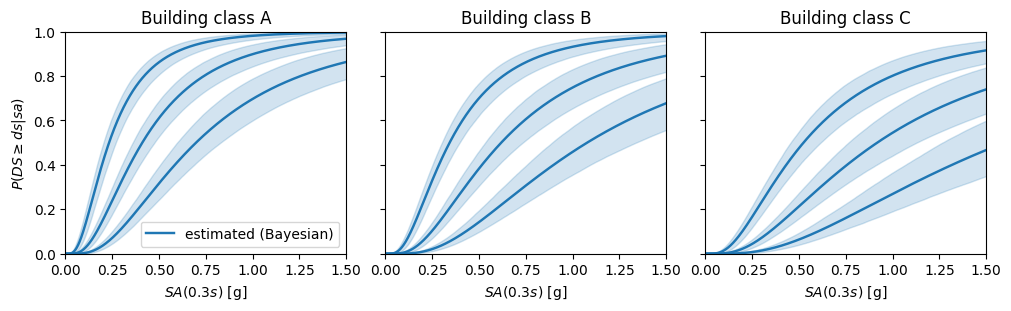

In [13]:
im = np.linspace(0.001,1.5,1000) # Horizontal axis

fig, axs = plt.subplots(1, 3, figsize=(10,3), sharey=True, constrained_layout=True)
for bc, ax in zip(args['list_bc'], axs):
    posterior.plot_frag_funcs(ax, bc=bc, im=im, color = 'tab:blue', 
                        kwargsm={'ls': '-', 'lw': 1.75, 'label': 'estimated (Bayesian)'})
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1.5])
    ax.set_xlabel('$SA(0.3s)$ [g]')
    ax.set_title('Building class ' + str(bc))
    if bc == args['list_bc'][0]:
        ax.set_ylabel('$P(DS \geq ds|sa)$')
        ax.legend()
plt.show()

Below, we illustrate how to store the results to a google drive (if the notebook runs on colab) or on your local machine.

The function `save_as_netcdf` exports the posterior samples of the fragility function parameters, $\boldsymbol{\vartheta}$.

The remainder of this notebook explains how to visualize the posterior IM values.


In [14]:
save_results = False
if save_results:
    # Specify the folder to store results
    res_dir = os.path.join('results', 'tutorial2', '')
    if os.getenv("COLAB_RELEASE_TAG"):
        from google.colab import drive
        drive.mount('/content/drive/',force_remount=True)
        # Modify this according to the path in your google drive !
        gdrive_dir = os.path.join('content', 'drive', 'MyDrive', '')
        res_dir = gdrive_dir + res_dir
    
    filepath = res_dir + 'Bayesian_frag_im_' + args['IM'] + '.nc'
    posterior.save_as_netcdf(filepath = filepath, include_z = False)

### Posterior IM at survey sites

Below, we compare the prior and posterior IM distribution at the **site of a surveyed building**. 

The prior $p(im|\mathbf{im}_\mathcal{S}, \mathbf{rup})$ is a log-normal distribution.

Through the Bayesian approach, we obtain samples from the posterior $p(im|\mathbf{ds}, \mathbf{im}_\mathcal{S}, \mathbf{rup})$, which is additionally conditioned on the damage survey data.


Here, we fit a normal distribution to the log-transformed $im$ posterior samples.

In [15]:
# Site ID to plot
sid = 100

# Prior: Conditional on station data and rupture characteristics
muB_prior = mu_B_S[sid] # Mean of logIM
_, varB_prior = gpr.predict(survey_sites, full_cov=False)
sigmaB_prior = np.sqrt(varB_prior)[sid] # Std. dev. of logIM

# Posterior: Conditional on damage data, station data and rupture characteristics
samplesB_post = posterior.get_logIM_samples(mu_B_S, L_BB_S)[sid,:]
muB_post, sigmaB_post = stats.norm.fit(samplesB_post, method='MM')

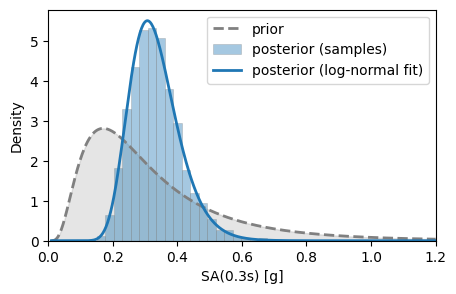

In [16]:
im_plot = np.linspace(0.01, 1.2, 500)

fig, ax = plt.subplots(figsize=(5,3))
# Prior
pdf = stats.lognorm.pdf(im_plot, s=sigmaB_prior, scale=np.exp(muB_prior))
ax.plot(im_plot, pdf, color='gray', lw=2, ls='--', label='prior')
ax.fill_between(im_plot, pdf, color='gray', alpha=0.2)
# Posterior
ax.hist(np.exp(samplesB_post), 20, density=True, color='tab:blue', alpha=0.4, 
    label='posterior (samples)', edgecolor='gray', lw=0.5)
pdf = stats.lognorm.pdf(im_plot, s=sigmaB_post, scale=np.exp(muB_post))
ax.plot(im_plot, pdf, color='tab:blue', lw=2, label='posterior (log-normal fit)')
ax.legend()
ax.set_xlim([0, 1.2])
ax.set_xlabel('SA(0.3s) [g]')
ax.set_ylabel('Density')
plt.show()

### Posterior predictive IM at new sites

Here, we compare the spatial distribution of prior and posterior IM values across a region of interest. For this purpose, we compute prior and posterior statistics for gridded sites that cover the region of interest. These sites are called **target sites** and we denote the corresponding IM values as $\mathbf{im}_\mathcal{T}$. Below, we first import the site information, in a similar way than for the survey and station sites before.

In [17]:
df = pd.read_csv(path_data + 'gridmap.csv', index_col = 'id')
res_gmm = np.load(path_data + 'gridmap_im_' + args['IM'] + 
                '_gmm_' + args['GMM'] + '.npz')
for key, value in res_gmm.items():
    df[key] = value

# Create sites
map_sites = Sites.from_df(df, column_site_mapping)

# For plotting
sh = (len(df.row.unique()), len(df.col.unique()))

Then, we compute the mean, 5% and 95% quantiles of the **prior** IM values at each target site. 
The prior is conditioned on station data and rupture characteristics, $p(\mathbf{im}_\mathcal{T}|\mathbf{im}_\mathcal{S}, \mathbf{rup})$.

In [18]:
# Mean and Variance of logIM (full_cov = False -> only diagonal of covariance matrix)
muT_prior, varT_prior = gpr.predict(map_sites, full_cov=False)

# Median IM and logarithmic standard deviation
temp_stats = np.append(np.exp(muT_prior[None, :]), np.sqrt(varT_prior[None,:]),axis=0)
imT_prior = xr.DataArray(temp_stats, dims = ['stat', 'sid'], 
                        coords = {'stat': ['median', 'stddev']})

Finally, we compute the mean, 5% and 95% quantiles of the **posterior** IM values at each target site. 
The posterior is conditioned on damage data, station data and rupture characteristics, $p(\mathbf{im}_\mathcal{T}|\mathbf{ds}, \mathbf{im}_\mathcal{S}, \mathbf{rup})$. Because the target sites are not identical to the building survey sites, we obtain this posterior predictive by marginalizing over the posterior IM values at the survey sites, $\mathbf{im}_\mathcal{B}$.

$p(\mathbf{im}_\mathcal{T}|\mathbf{ds}, \mathbf{im}_\mathcal{S}, \mathbf{rup}) = \int p(\mathbf{im}_\mathcal{T}|\mathbf{im}_\mathcal{B}, \mathbf{im}_\mathcal{S}, \mathbf{rup}) p(\mathbf{im}_\mathcal{B}|\mathbf{ds}, \mathbf{im}_\mathcal{S}, \mathbf{rup}) \, \mathrm{d}\mathbf{im}_\mathcal{B}$

The `PosteriorPredictiveIM` object performs this marginalization in a computationally efficient manner. 

In [19]:
from bayesfrag.postprocess import PosteriorPredictiveIM
postpredIM = PosteriorPredictiveIM(GPR = gpr, survey_sites = survey_sites)

samplesT_post = postpredIM.sample(args['mcmc_seed'], map_sites, posterior.samples['z'].values, 
                            L_BB_S, full_cov = False)

temp_stats = np.append(np.exp(np.mean(samplesT_post, axis=0))[None,:],
                       np.std(samplesT_post, axis=0)[None,:], axis=0)

imT_post = xr.DataArray(temp_stats, dims = ['stat', 'sid'], 
                    coords = {'stat': ['median', 'stddev']})

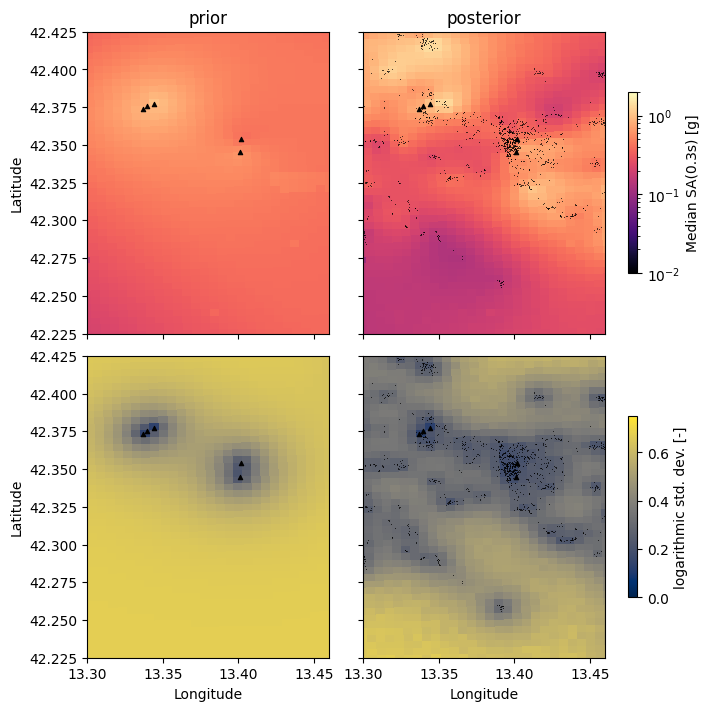

In [20]:
X = map_sites.coor[:, 0].reshape(sh)
Y = map_sites.coor[:, 1].reshape(sh)

normas = [mpl.colors.LogNorm(vmin=0.01, vmax=2), mpl.colors.Normalize(vmin=0, vmax=0.75)]
cmaps = [plt.get_cmap('magma'), plt.get_cmap('cividis')]
stats = ['median', 'stddev']
titles = ['prior', 'posterior']
cbar_labels = ['Median SA(0.3s) [g]', 'logarithmic std. dev. [-]']
fig, axss = plt.subplots(2, 2, figsize=(7, 7), sharey='row', sharex='col',
                        constrained_layout=True)
for k in range(2):
    axs = axss[k,:]
    vals = [imT_prior.loc[stats[k]].values, imT_post.loc[stats[k]].values]

    for i, ax in enumerate(axs):
        Z = vals[i].reshape(sh)
        im = ax.pcolormesh(X, Y, Z, norm=normas[k], cmap=cmaps[k])
        ax.scatter(station_sites.coor[:,0], station_sites.coor[:,1], color='black',
                    marker='^', s=10, lw=0.8)
        if i == 1: 
            ax.scatter(survey_sites.coor[:,0], survey_sites.coor[:,1], 
                    marker='.', color='black', s=0.8, lw=0.2)
        ax.set_xlim([13.3, 13.46])
        ax.set_ylim([42.225, 42.425])
        if k == 0: ax.set_title(titles[i])
        if i == 0: ax.set_ylabel('Latitude')
        if k == 1: ax.set_xlabel('Longitude')
        ax.set_aspect('equal')
    cbar = fig.colorbar(im, ax=axs[:], 
                orientation ='vertical', shrink=0.6, 
                label=cbar_labels[k], pad=0.035,)
plt.show()

Below, we save the prior and posterior IM estimates at the target sites for visualization purposes.

In [21]:
if save_results:
    ds = xr.Dataset({'imT_prior': imT_prior, 'imT_post' : imT_post})
    ds.attrs = posterior.samples.attrs
    ds.to_netcdf(res_dir + 'IMresults_im_' + args['IM'] + '.nc')